In [138]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import gaussian_kde

## Data Prep

In [139]:
df = pd.read_excel('Analysis_Data.xlsx', sheet_name='Drilling Cost')
df.columns = ['Date', 'Crude_Oil_Drill_Cost', 'Natural_Gas_Drill_Cost', 'Dry_Well_Drill_Cost',
               'Arithmetic_Return_Crude_Oil', 'Arithmetic_Return_Natural_Gas', 'Arithmetic_Return_Dry_Well']

df = df.iloc[2:] # Remove top 2 rows
df.replace('.', np.nan, inplace=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)


# cast date as dt and filter
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 1990) & (df['Date'].dt.year <= 2006)]

# calculate avg costs and returns
df['AVG_Cost'] = df.iloc[:,1:4].mean(axis=1)
df['AVG_Return'] = df.iloc[:,4:7].mean(axis=1)

df.head()

C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_1656\3512073622.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('.', np.nan, inplace=True)


,Date,Crude_Oil_Drill_Cost,Natural_Gas_Drill_Cost,Dry_Well_Drill_Cost,Arithmetic_Return_Crude_Oil,Arithmetic_Return_Natural_Gas,Arithmetic_Return_Dry_Well,AVG_Cost,AVG_Return
32,1990-06-30,321.8,471.3,367.5,0.139922,0.029489,0.034046,386.866667,0.067819
33,1991-06-30,346.9,506.6,441.2,0.077999,0.074899,0.200544,431.566667,0.117814
34,1992-06-30,362.3,426.1,357.6,0.044393,-0.158902,-0.189483,382.000000,-0.101331
35,1993-06-30,356.6,521.2,387.7,-0.015733,0.223187,0.084172,421.833333,0.097209
36,1994-06-30,409.5,535.1,491.5,0.148345,0.026669,0.267733,478.700000,0.147582


## Checking Normality 

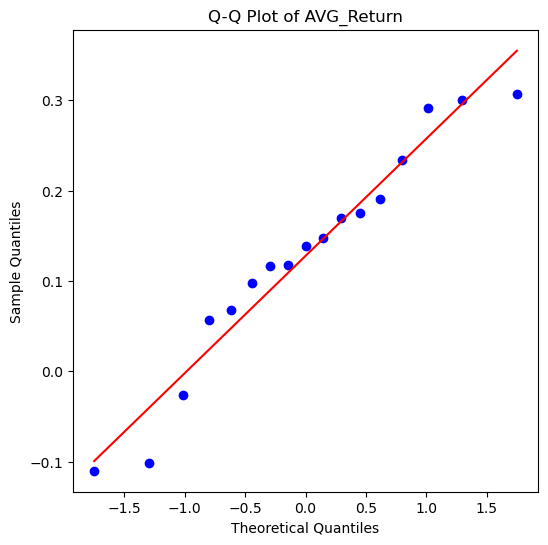

In [140]:
# Create a Q-Q plot
fig, ax = plt.subplots(figsize=(6, 6))  # Set figure size
stats.probplot(df['AVG_Return'], dist="norm", plot=ax)

# Customize title and labels
ax.set_title("Q-Q Plot of AVG_Return")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")

plt.show()


In [141]:
stat, p = stats.shapiro(df['AVG_Return'])
print(f"Shapiro-Wilk Test: Statistic={stat:.4f}, p-value={p:.4f}")

Shapiro-Wilk Test: Statistic=0.9440, p-value=0.3689


Seems like arithmetic changes from one year to the next from 2006 to 2012 **do not** follow a Normal 
distribution. Assuming that from 2006 to 2012 changes were relatively consistent in their distribution compaired to past years.

## Future Returns Using With Kernel Density Estimate

In [142]:
np.random.seed(88)
kernel = gaussian_kde(df['AVG_Return'])
D = []

for i in range(10000):
    ret = np.random.normal(loc = df['AVG_Return'].mean(), scale = df['AVG_Return'].std())
    P0 = df['AVG_Cost'].iloc[-1] # Init at last avg cost
    Pt = P0 * (1 + ret)
    for j in range(18):
        if j <= 5:
            ret = kernel.resample(size = 1).item()
            Pt = Pt * (1 + ret)
        elif j > 5 and j <= 8:
            ret = np.random.triangular(left = -0.22, mode = -0.0917, right = -0.07)
            Pt = Pt * (1 + ret)
        elif j > 8 and j <= 18:
            ret = np.random.triangular(left = 0.02, mode = 0.05, right = 0.06)
            Pt = Pt * (1 + ret)
    D.append(Pt)
data_kernel = pd.DataFrame(D)

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


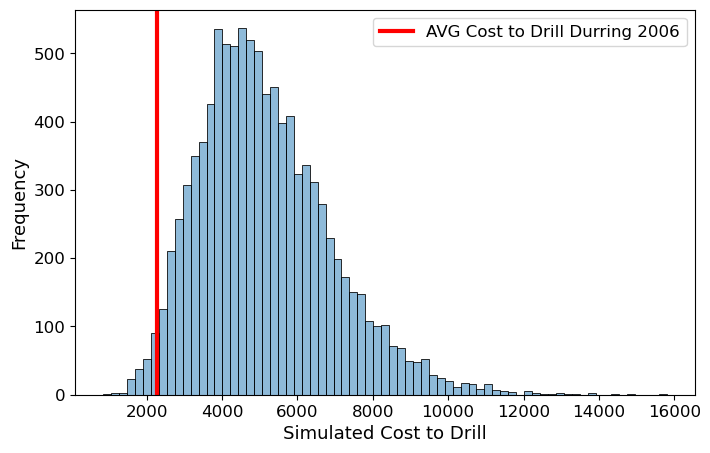

In [143]:
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(data=data_kernel)
ax.axvline(x=df['AVG_Cost'].iloc[-1], color="red", linewidth=3, label="AVG Cost to Drill Durring 2006")

ax.set_xlabel("Simulated Cost to Drill", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)

ax.legend(fontsize=12)  # Increase legend font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


## Future Returns Assuming Normality 

In [144]:
np.random.seed(88)
D = []

for i in range(10000):
    ret = np.random.normal(loc = df['AVG_Return'].mean(), scale = df['AVG_Return'].std())
    P0 = df['AVG_Cost'].iloc[-1] # Init at last avg cost
    Pt = P0 * (1 + ret)
    for j in range(18):
        if j <= 5:
            ret = np.random.normal(loc = df['AVG_Return'].mean(), scale = df['AVG_Return'].std())
            Pt = Pt * (1 + ret)
        elif j > 5 and j <= 8:
            ret = np.random.triangular(left = -0.22, mode = -0.0917, right = -0.07)
            Pt = Pt * (1 + ret)
        elif j > 8 and j <= 18:
            ret = np.random.triangular(left = 0.02, mode = 0.05, right = 0.06)
            Pt = Pt * (1 + ret)
    D.append(Pt)
data_normal = pd.DataFrame(D)

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


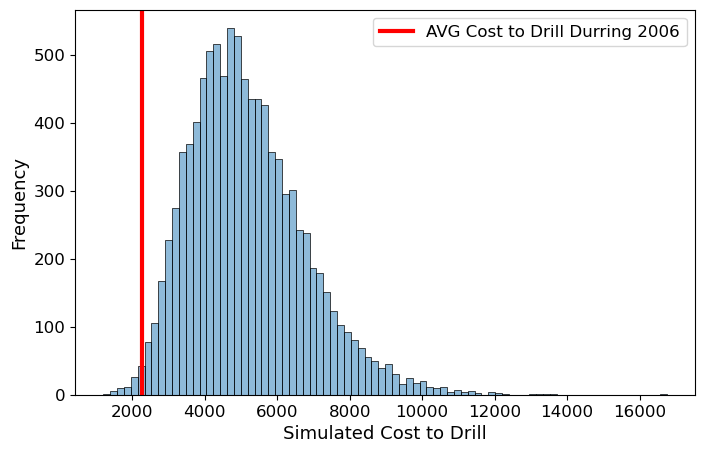

In [145]:
plt.figure(figsize=(8, 5)) 
ax = sns.histplot(data=data_normal)
ax.axvline(x=df['AVG_Cost'].iloc[-1], color="red", linewidth=3, label="AVG Cost to Drill Durring 2006")

ax.set_xlabel("Simulated Cost to Drill", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)

ax.legend(fontsize=12)  # Increase legend font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


## So Which Simulation Should The Company Use?

c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\anaconda\envs\ds\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_grou

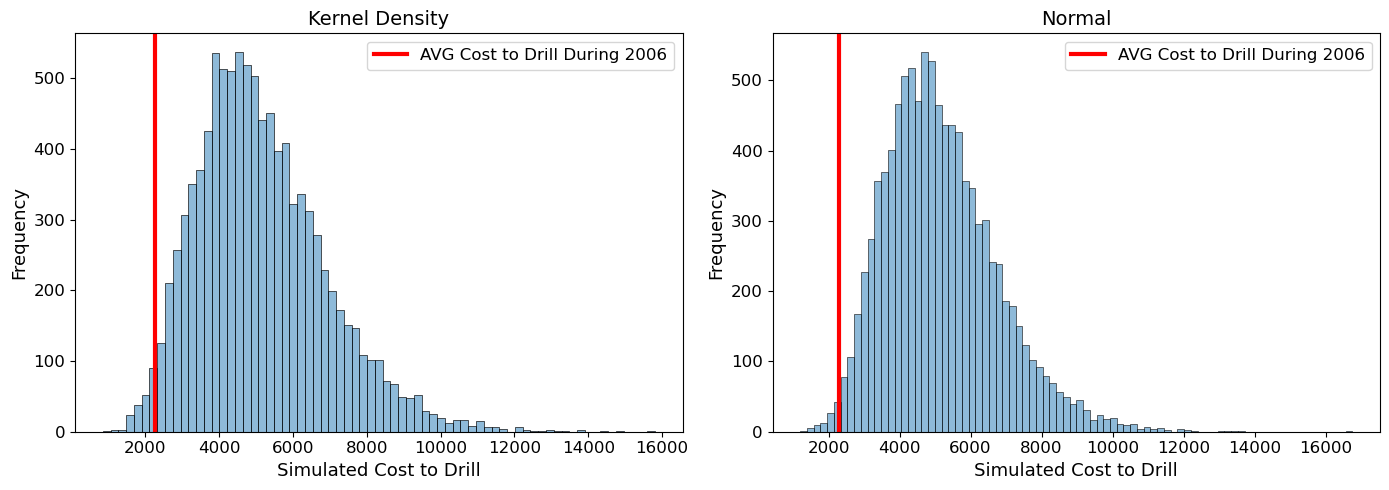

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Create side-by-side plots

# kde
sns.histplot(data=data_kernel, ax=axes[0])
axes[0].axvline(x=df['AVG_Cost'].iloc[-1], color="red", linewidth=3, label="AVG Cost to Drill During 2006")
axes[0].set_xlabel("Simulated Cost to Drill", fontsize=13)
axes[0].set_ylabel("Frequency", fontsize=13)
axes[0].set_title("Kernel Density", fontsize=14)
axes[0].legend(fontsize=12)
axes[0].tick_params(axis="both", labelsize=12)

# N
sns.histplot(data=data_normal, ax=axes[1])
axes[1].axvline(x=df['AVG_Cost'].iloc[-1], color="red", linewidth=3, label="AVG Cost to Drill During 2006")
axes[1].set_xlabel("Simulated Cost to Drill", fontsize=13)
axes[1].set_ylabel("Frequency", fontsize=13)
axes[1].set_title("Normal", fontsize=14)  # Title
axes[1].legend(fontsize=12)
axes[1].tick_params(axis="both", labelsize=12)

plt.tight_layout()
plt.show()


In [147]:
print("How often we at least break even with KDE:")
print(data_kernel[data_kernel>=df['AVG_Cost'].iloc[-1]].count()/data_kernel.shape[0])
print("\nHow often we at least break even with Normality:")
data_normal[data_normal>=df['AVG_Cost'].iloc[-1]].count()/data_normal.shape[0]

How often we at least break even with KDE:
0    0.9814
dtype: float64

How often we at least break even with Normality:


0    0.9922
dtype: float64

For this reason I recommend  using the KDE dist.